

# Optimización de  Mixtral 8x7B usando PEFT y QLoRA

Este notebook muestra un laboratorio de como es posible afinal [Mixtral 8x7B](https://huggingface.co/mistralai/Mixtral-8x7B-v0.1) Mixture of Experts (MoE).


Este experimento utiliza QLoRA, un método de afinamiento que combina cuantización y LoRA. El LLM es cargado en 4 bits utilizando bitsandbytes y utiliza LoRA para entrenar usando la biblioteca PEFT de Hugging Face 🤗.

### 1. Creación del ambiente Cloud con GPU

Este laboratorio fue relizado usando un GPU y el ambiente de desarrollo de [brev.dev](https://brev.dev). Siguiendo el enlanc del badge es posible crear una instancia utilizando este Notebook:

[![](https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brevdeploynavy.svg)](https://console.brev.dev/environment/new?instance=T4:g4dn.12xlarge&diskStorage=512&name=mixtral-finetune-own-data&file=https://github.com/brevdev/notebooks/raw/main/mixtral-finetune-own-data.ipynb&python=3.10&cuda=12.1.1)

Como ambiente de ejecución se utilizó:

4xT4 (as linked) con 16GB GPU por GPU was enough for me . (3.91 USD/hora)

El ambiente de desarrollo utilizó  **Python 3.10 and CUDA 12.1.1**.



#### Paquetes necesarios



In [1]:
!pip install --upgrade pip
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib

#### Accelerator
Se instala [Accelerator](https://huggingface.co/docs/accelerate/package_reference/accelerator), quizás no es del todo necesario por las optmizaciones aplicadas por LoRA.

In [2]:
#from accelerate import FullyShardedDataParallelPlugin, Accelerator
#from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

#fsdp_plugin = FullyShardedDataParallelPlugin(
#    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
#    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
#)

#accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

#### Weights & Biases para monitoreo de métricas


In [2]:
!pip install -q wandb -U

import wandb, os

os.environ["WANDB_API_KEY"] = "05bbac2bfe5c0b97d3278f791c1c065fb884f074"
os.environ["HF_TOKEN"] = "umr.AUW!bmf0rjw0fkg"
wandb_project = "gbif-datasets-peft"
os.environ["WANDB_PROJECT"] = wandb_project
wandb.login()
    

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: federicomh (gbifdatasets). Use `wandb login --relogin` to force relogin


True

#### Carga de datasets

In [4]:
from datasets import load_dataset

train_dataset = load_dataset('text', data_files='train.txt', split='train')
eval_dataset = load_dataset('text', data_files='test.txt', split='train')

#### Formatting prompts
Then create a `formatting_func` to structure training examples as prompts.

In [5]:
def formatting_func(dataset_txt):
    text = f"### {dataset_txt}"
    return text

### 2. Carga del modelo base

Se definen las configuraciones de cuantización, del modelo. 4 bits (load_in_4bit=True) con doble cuantización (bnb_4bit_use_double_quant=True), tipo de cálculo en 4 bits (bnb_4bit_compute_dtype=torch.bfloat16), carga en 8 bits con procesamiento en punto flotante de 32 bits en la CPU (load_in_8bit_fp32_cpu_offload=True) y habilita la cuantización en punto flotante de 32 bits en la CPU (llm_int8_enable_fp32_cpu_offload=True).

In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mixtral-8x7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    # load_in_8bit_fp32_cpu_offload=True,
    # llm_int8_enable_fp32_cpu_offload=True
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

### 3. Tokenización

Se define el tokenizador utilizando padding a la izquierda, en teoría utiliza [menos memoria](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).

In [7]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

Se reformatea los datos para el formato de prompt

In [8]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Se obtiene una distribución de la longitude de los datasets para definir un `max_length` apropiado.

54


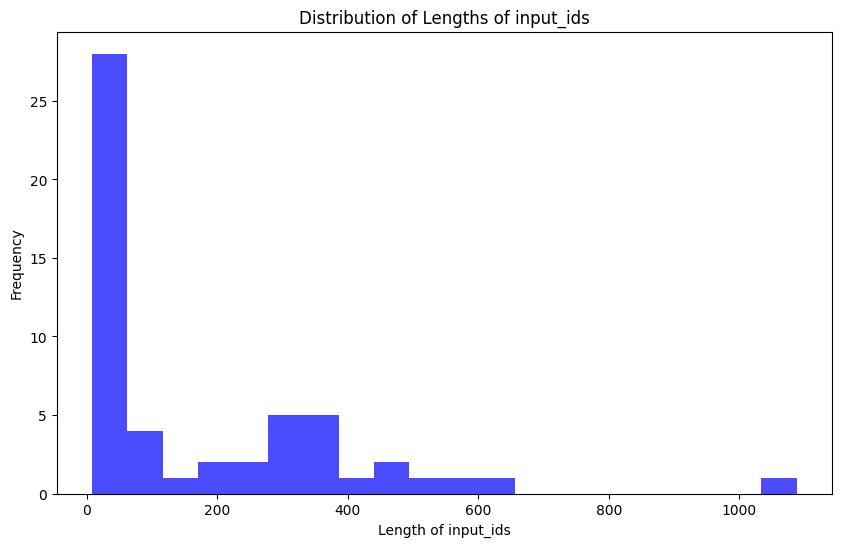

In [9]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

Se procede a tokenizar con padding y máximo de tamaño (truncamiento).[self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning).

In [10]:
max_length = 512

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [11]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Se verifica que `input_ids` contiene el padding con  `eos_token` (2) que hay un `eos_token`al final, y que el prompt inicia con `bos_token` (1).

In [12]:
print(tokenized_train_dataset[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

Todos los input debe ser del mismo tamaño, `max_length`.

54


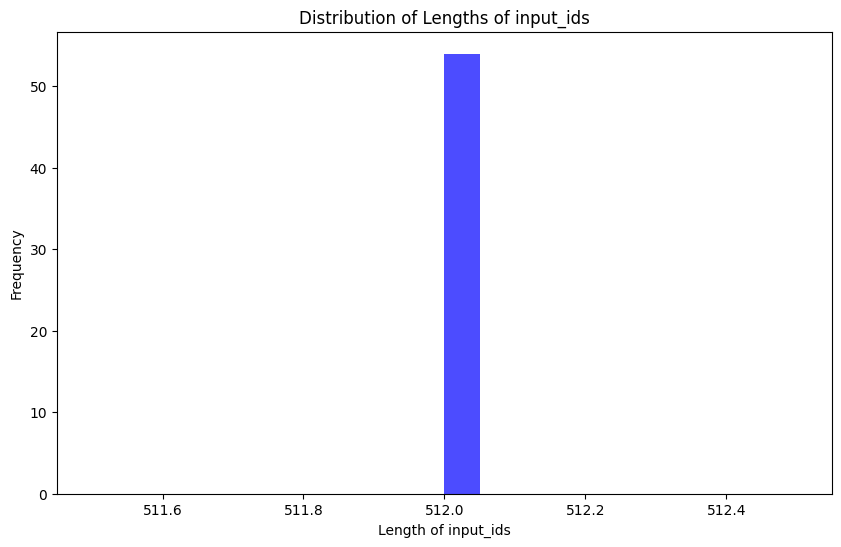

In [13]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

### 4. Configuración de LoRA

Para iniciar el afinamiento del modelo se utiliza el método`prepare_model_for_kbit_training` de PEFT.

In [14]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [15]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Se imprime las capas del modelo y LoRA se aplica a todas las capas lineales del modelo `q_proj`, `k_proj`, `v_proj`, `o_proj`, `w1`, `w2`, `w3`, y `lm_head`.

In [16]:
print(model)

MixtralForCausalLM(
  (model): MixtralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MixtralDecoderLayer(
        (self_attn): MixtralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MixtralRotaryEmbedding()
        )
        (block_sparse_moe): MixtralSparseMoeBlock(
          (gate): Linear4bit(in_features=4096, out_features=8, bias=False)
          (experts): ModuleList(
            (0-7): 8 x MixtralBLockSparseTop2MLP(
              (w1): Linear4bit(in_features=4096, out_features=14336, bias=False)
              (w2): Linear4bit(in_features=14336, out_features=4096, bias=False)
              (w3): Linear4bit(in_features=4096, out_

Se definen las opciones de configuración de LoRA, en donde: `r` es el rango de la matriz de baja dimensión utilizada en los adaptadores, lo que controla la cantidad de parámetros entrenados. Un rango más alto permitirá una mayor expresividad, pero también conlleva un compromiso en términos de recursos de cómputo. `alpha` es el factor de escala para los pesos aprendidos. La matriz de pesos se escala por alpha/r, por lo que un valor más alto para alpha asigna más peso a las activaciones de LoRA.

In [17]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "w1",
        "w2",
        "w3",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 481402880 || all params: 23964004352 || trainable%: 2.0088582564450372


See how the model looks different now, with the LoRA adapters added:

In [18]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MixtralForCausalLM(
      (model): MixtralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MixtralDecoderLayer(
            (self_attn): MixtralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer):

### 5. Entrenamiento del modelo

Se entrena el modelo utilizando max_steps=200 (iteraciones), este debe actualizar de acuerdo con el análisis de sobre ajuste del modelo.

In [19]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

In [20]:
if torch.cuda.device_count() > 1: # Si hay más de un GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [23]:
import transformers
from datetime import datetime

project = "gbif-datasets-lora"
base_model_name = "mixtral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=200,
        learning_rate=2.5e-5,
        fp16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,
        logging_dir="./logs",
        save_strategy="steps",
        save_steps=25,
        evaluation_strategy="steps",
        eval_steps=25,
        do_eval=True,
        report_to="wandb",
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False
with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable :
    trainer.train()

Step,Training Loss,Validation Loss
25,1.618900,1.175222
50,0.948100,1.192527
75,0.856500,1.190523
100,0.520300,1.264171
125,0.312900,1.309890
150,0.244000,1.344730
175,0.164300,1.439314
200,0.110000,1.461457


/home/ubuntu/.pyenv/versions/3.10.13/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/ubuntu/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/ubuntu/.pyenv/versions/3.10.13/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warning

### 6. Probar el modelo entrenado

Es recomendable detener el proceso actual e iniciar de nuevo el ambiente.
Dado que PEFT sólo guarda el valor de los adaptadores QLoRA es necesario cargar el modelo base desde Huggingface Hub:

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mixtral-8x7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    use_auth_token=True
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

/home/ubuntu/.pyenv/versions/3.10.13/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

Ahora se carga el adaptador QLoRA desde el directorio de checkpoint:

In [4]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mixtral-gbif-datasets-lora/checkpoint-200")

Ahora se evalua el modelo usando el mismo `eval_prompt` y `model_input`.
Se define una penaldad de repetición de 1.15.

In [6]:
eval_prompt = " Describe the GBIF dataset 'Checklist of Vermont Species': # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=150,
                                             repetition_penalty=1.15)[0],
                           skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Describe the GBIF dataset 'Checklist of Vermont Species': # 10,378 occurrences; 2,594 species.

The Checklist is a compilation of all native and naturalized taxa (species, subspecies or varieties) reported from Vermont as well as those considered to be historical but possibly extirpated. It includes vascular plants, bryophytes, lichens, fungi, algae, invertebrates and vertebrates. The checklist was compiled by state biologists with assistance from many other experts throughout New England. This inventory represents an important first step for conservation planning at local, regional and national levels.
